# Question A2 (10 marks)

>In this question, we will determine the optimal learning rate for mini-batch gradient descent. Find the optimal learning rate for mini-batch gradient descent by training the neural network and evaluating the performances for different learning rates. Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

>Plot mean cross-validation accuracies on the final epoch for different learning rates as a scatter plot. Limit search space to learning rates {0.001, 0.005, 0.0001, 0.0005}. 

>Next, create a table of number of epochs required to reach convergence against different learning rates. 

>Finally, select the optimal learning rate and state a reason for your selection.

>This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

---

## 1. Paste codes from Part A_1

> To reduce repeated code, place your
> - network (MLP defined in QA1)
> - torch datasets (CustomDataset defined in QA1)
> - loss function (loss_fn defined in QA1)
> in a separate file called common_utils.py

> Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

> The following code cell will not be marked.

The codes that we will be importing are
- `MLP` class: This class is robust and can handle any hyperparameters
- `preprocess_dataset` method: Scaling of features is always a good practise
- `initialize_loaders` method: We are still loading the same dataset by batches per epoch, and we can choose which subset of the dataset is used to create the loader.
- `train_one_epoch` and `evaluate` methods: We are essentially doing Part A1 5 times (corresponding to 5 folds), and for each time we have a different training and testing dataset.

What we are NOT importing
- `preprocess` method that we created in A1: It does a train-test split which is not what we want to do in this case (we are doing cv folds here)

In [4]:
from common_utils import MLP, preprocess_dataset, intialise_loaders, train_one_epoch, evaluate

df = pd.read_csv('simplified.csv')

# Encode labels as integers
label_encoder = preprocessing.LabelEncoder()
df['label'] = df['filename'].str.split('_').str[-2]
df['label'] = label_encoder.fit_transform(df['label'])

# Prepare training data and labels
X_train: np.ndarray = df.drop(columns=['filename', 'label']).values
y_train: np.ndarray = df['label'].values

---

## 2. Define different folds

>Define different folds for different learning rates to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [5]:
def generate_cv_folds_for_learning_rates(
        parameters  : list[int] ,   # List of learning rates to generate folds for
        X_train     : np.ndarray, 
        y_train     : np.ndarray
    ):
    """
    Generate cross-validation folds for each learning rate in the parameters list.
    For each learning rate, we create 5 folds of the training data, preprocess them, 
    and store the scaled training and validation matrices along with their corresponding labels in dictionaries.

    Args:
        parameters(list[int]): A list of learning rates for which to generate cross-validation folds.
        X_train(np.ndarray): The training data features.
        y_train(np.ndarray): The training data labels.

    Returns:
        X_train_scaled_dict (dict): Keys are learning rates and values are lists of the preprocessed training matrices for the different folds.
        X_val_scaled_dict (dict): Keys are learning rates and values are lists of the processed validation matrices for the different folds.
        y_train_dict (dict): Keys are learning rates and values are lists of labels for the different folds
        y_val_dict (dict): Keys are learning rates and values are lists of labels for the different folds
    """
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    X_train_scaled_dict : dict[int, list[np.ndarray]] = {}
    X_val_scaled_dict   : dict[int, list[np.ndarray]] = {}
    y_train_dict        : dict[int, list[np.ndarray]] = {}
    y_val_dict          : dict[int, list[np.ndarray]] = {}

    for learning_rate in parameters:

        X_train_scaled_dict[learning_rate]  = []
        X_val_scaled_dict[learning_rate]    = []
        y_train_dict[learning_rate]         = []
        y_val_dict[learning_rate]           = []

        for train_indices, test_indices in kf.split(X_train):

            X_train_fold, X_val_fold = X_train[train_indices], X_train[test_indices]
            y_train_fold, y_val_fold = y_train[train_indices], y_train[test_indices]
            
            X_train_fold_scaled, X_test_fold_scaled = preprocess_dataset(X_train_fold, X_val_fold)
            
            # Store the scaled data and labels in the respective dictionaries
            X_train_scaled_dict[learning_rate].append(X_train_fold_scaled)
            X_val_scaled_dict[learning_rate].append(X_test_fold_scaled)
            y_train_dict[learning_rate].append(y_train_fold)
            y_val_dict[learning_rate].append(y_val_fold)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

learning_rates = [0.001, 0.005, 0.0001, 0.0005]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_learning_rates(learning_rates, X_train, y_train)

---

## 3. Hyperparameter Tuning

>Perform hyperparameter tuning for the different learning rates with 5-fold cross validation.

In [9]:
NUM_EPOCHS          = 200
NUM_FOLDS           = 5
BATCH_SIZE          = 64

In [10]:
def find_optimal_hyperparameter(
        X_train_scaled_dict : dict[int, list[np.ndarray]],
        X_val_scaled_dict   : dict[int, list[np.ndarray]],
        y_train_dict        : dict[int, list[np.ndarray]], 
        y_val_dict          : dict[int, list[np.ndarray]], 
        parameters          : list[int], 
        parameter_name      : str
    ):
    """
    Returns:
        cross_validation_accuracies(dict): Keys are learning rates and values are lists of the accuracies for the different folds.
        cross_validation_times(dict): Keys are learning rates and values are lists of the times taken for the different folds.
    """
    cross_validation_accuracies = {}
    cross_validation_times = {}

    print (f"Finding optimal {parameter_name}...")

    for learning_rate in parameters:
        print (f"Evaluating {parameter_name} = {learning_rate}...")

        accuracies  = []    # List to store accuracies for each fold
        times       = []    # List to store time taken for each fold

        for fold in range (NUM_FOLDS):
            print (f"  Fold {fold+1}...") # 2 space

            X_train_scaled  = X_train_scaled_dict[learning_rate][fold]
            X_val_scaled    = X_val_scaled_dict[learning_rate][fold]
            y_train_fold    = y_train_dict[learning_rate][fold]
            y_val_fold      = y_val_dict[learning_rate][fold]

            train_data_loader, val_data_loader = intialise_loaders(
                X_train_scaled  , 
                y_train_fold    , 
                X_val_scaled    , 
                y_val_fold      ,
                batch_size      = BATCH_SIZE
            )

            start_time = time.time()
            
            model = MLP(
                num_features        = 77, 
                num_hidden_layers   = 3, 
                hidden_widths       = [128, 128, 128],
                num_labels          = 1, 
                dropout             = 0.3
            )

            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr           = learning_rate,
                weight_decay = 0.0005   
            )

            loss_fn = nn.BCELoss()

            patience            = 5             # Number of epochs to wait for improvement in test loss before stopping training
            max_val_accuracy    = 0.0           # Initialize best accuracy to 0 so that any improvement will be detected
            patience_counter    = 0             # Counter to track how many epochs have passed without improvement in test loss
            best_epoch          = 0             # To track the epoch at which the best model was saved
            
            # Evaluate the model with early stopping
            for epoch in range(NUM_EPOCHS):
                train_loss, train_acc   = train_one_epoch(model, train_data_loader, loss_fn, optimizer)
                val_loss, val_acc       = evaluate(model, val_data_loader, loss_fn)

                # Print progress every 20 epochs
                if (epoch + 1) % 20 == 0:
                    print(f"    Epoch [{epoch+1}/{NUM_EPOCHS}] - " # 4 space
                        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                        f"Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}") 

                # Early stopping logic
                # We use accuracy instead of loss as we only interested in best accuracy
                if val_acc > max_val_accuracy:
                    max_val_accuracy = val_acc
                    patience_counter = 0
                    best_epoch = epoch
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"    Early stopping at epoch {epoch+1} for learning rate {learning_rate}") # 4 space
                    break

            print (f"    Best validation accuracy for learning rate {learning_rate} in fold {fold+1}: {max_val_accuracy:.4f} at epoch {best_epoch+1}") # 4 space

            accuracies.append(max_val_accuracy)
            
            end_time = time.time()
            fold_time = end_time - start_time
            times.append(fold_time)

        cross_validation_accuracies[learning_rate] = accuracies
        cross_validation_times[learning_rate] = times

    return cross_validation_accuracies, cross_validation_times

In [11]:
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(
    X_train_scaled_dict, 
    X_val_scaled_dict, 
    y_train_dict, 
    y_val_dict, 
    learning_rates, 
    'learning_rate'
)

Finding optimal learning_rate...
Evaluating learning_rate = 0.001...
  Fold 1...
    Epoch [20/200] - Train Loss: 0.4838, Train Acc: 0.7683 | Test Loss: 0.5583, Test Acc: 0.7106
    Early stopping at epoch 27 for learning rate 0.001
    Best validation accuracy for learning rate 0.001 in fold 1: 0.7488 at epoch 22
  Fold 2...
    Epoch [20/200] - Train Loss: 0.4893, Train Acc: 0.7571 | Test Loss: 0.5382, Test Acc: 0.7181
    Epoch [40/200] - Train Loss: 0.3960, Train Acc: 0.8234 | Test Loss: 0.5030, Test Acc: 0.7604
    Early stopping at epoch 41 for learning rate 0.001
    Best validation accuracy for learning rate 0.001 in fold 2: 0.7649 at epoch 36
  Fold 3...
    Epoch [20/200] - Train Loss: 0.4974, Train Acc: 0.7582 | Test Loss: 0.5308, Test Acc: 0.7312
    Early stopping at epoch 22 for learning rate 0.001
    Best validation accuracy for learning rate 0.001 in fold 3: 0.7341 at epoch 17
  Fold 4...
    Epoch [20/200] - Train Loss: 0.4906, Train Acc: 0.7527 | Test Loss: 0.5368, T

---

## 4. Visulization

Plot scatterplot of mean cross validation accuracies for the different learning rates.

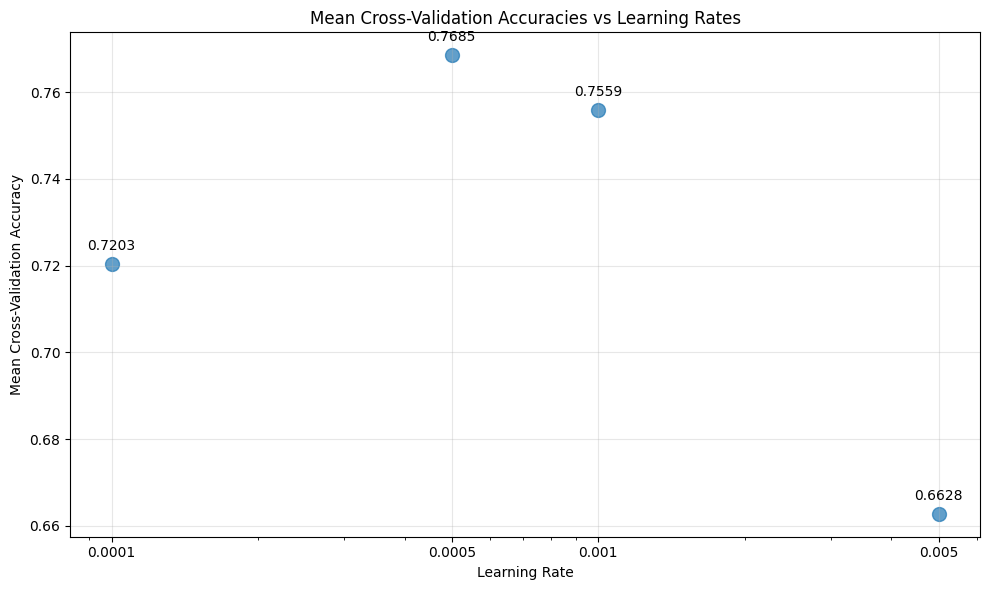

Mean Cross-Validation Accuracies:
Learning Rate 0.0001: 0.7203
Learning Rate 0.0005: 0.7685
Learning Rate 0.001: 0.7559
Learning Rate 0.005: 0.6628


In [12]:
# Calculate mean cross-validation accuracies for each learning rate
mean_accuracies = {learning_rate: np.mean(accuracies) for learning_rate, accuracies in cross_validation_accuracies.items()}

# Sort for cleaner plotting
x_vals = sorted(mean_accuracies.keys())
y_vals = [mean_accuracies[lr] for lr in x_vals]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, s=100, alpha=0.7)

plt.xlabel('Learning Rate')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracies vs Learning Rates')
plt.grid(True, alpha=0.3)
plt.xscale('log')

# Force one tick label per learning-rate point
plt.xticks(x_vals, [f"{lr:.4g}" for lr in x_vals])

# Add value labels on each point
for lr, acc in zip(x_vals, y_vals):
    plt.annotate(f'{acc:.4f}', (lr, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print("Mean Cross-Validation Accuracies:")
for lr, acc in zip(x_vals, y_vals):
    print(f"Learning Rate {lr}: {acc:.4f}")

---

## 5. Optimal Learning Rate

Create a table of number of epochs required to reach convergence against different learning rates. Select the optimal learning rate and state a reason for your selection.

In [13]:
mean_times = {learning_rate: np.mean(times) for learning_rate, times in cross_validation_times.items()}

df = pd.DataFrame({
    'Learning Rate'         : list(mean_times.keys()),
    'Mean Time (seconds)'   : list(mean_times.values()),
    'Accuracy'              : list(mean_accuracies.values())
})

df

,Learning Rate,Mean Time (seconds),Accuracy
0,0.0010,2.562198,0.755909
1,0.0050,2.001662,0.662769
2,0.0001,5.424999,0.720328
3,0.0005,2.973104,0.768516


**Optimal Learning Rate = 0.0005**

It resulted in the highest accuracy among all 4 learning rates. On the other hand, learning rate of 0.0010 sacrifised accuracy slightly with faster mean time to convergence. While the difference in time is insignificant here, if the dataset happens to be very large, learning rate of 0.00010 can be considered as well.